In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 21

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 21)                231       
                                                                 
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
113/118 [===========================>..] - ETA: 0s - loss: 2.9204 - accuracy: 0.1180
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
118/118 [==============================] - 2s 6ms/step - loss: 2.9130 - accuracy: 0.1193 - val_loss: 2.6702 - val_accuracy: 0.2136
Epoch 2/1000
 99/118 [========================>.....] - ETA: 0s - loss: 2.6157 - accuracy: 0.1709
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
118/118 [==============================] - 0s 3ms/step - loss: 2.5927 - accuracy: 0.1751 - val_loss: 2.3237 - val_accuracy: 0.2994
Epoch 3/1000
116/118 [============================>.] - ETA: 0s - loss: 2.3505 - accuracy: 0.2124
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
118/118 [==============================] - 0s 3ms/step - loss: 2.3501 - accuracy: 0.2124 - val_loss: 2.0696 - val_accuracy: 0.3526
Epoch 4/1000
116/118 [============================>.] - ETA: 0s - loss: 2.1904 - accu

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

40/40 [==============================] - 0s 844us/step - loss: 0.5384 - accuracy: 0.8870


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 67ms/step
[2.3124577e-02 2.8888485e-01 1.6095954e-03 4.1011381e-03 1.5147790e-02
 9.2537347e-03 1.1957734e-03 4.7816406e-04 3.0637059e-02 2.0636130e-02
 2.5508472e-01 5.3586783e-03 5.8944500e-04 2.1305757e-02 1.9750962e-01
 3.4701373e-02 7.0268139e-03 6.6932760e-02 3.6527624e-04 1.6056756e-02
 4.4704067e-11]
1


# 混同行列

157/157 [==============================] - 0s 611us/step


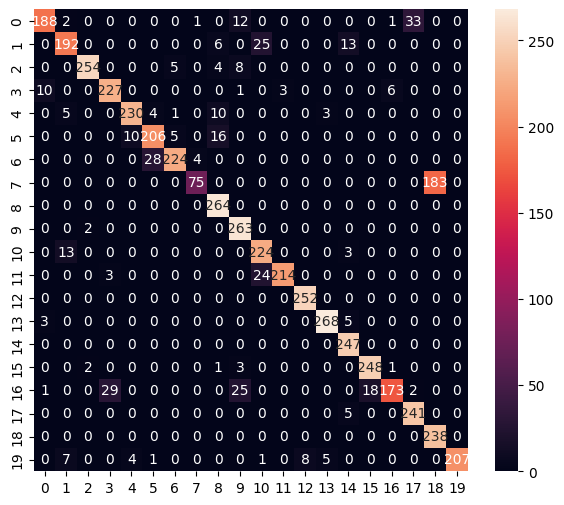

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       237
           1       0.88      0.81      0.84       236
           2       0.98      0.94      0.96       271
           3       0.88      0.92      0.90       247
           4       0.94      0.91      0.93       253
           5       0.86      0.87      0.87       237
           6       0.95      0.88      0.91       256
           7       0.94      0.29      0.44       258
           8       0.88      1.00      0.93       264
           9       0.84      0.99      0.91       265
          10       0.82      0.93      0.87       240
          11       0.99      0.89      0.93       241
          12       0.97      1.00      0.98       252
          13       0.97      0.97      0.97       276
          14       0.90      1.00      0.95       247
          15       0.93      0.97      0.95       255
          16       0.96      0.70      0.81       248
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmpcme2721_\assets


INFO:tensorflow:Assets written to: C:\Users\asus\AppData\Local\Temp\tmpcme2721_\assets


7292

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.3124591e-02 2.8888488e-01 1.6095941e-03 4.1011367e-03 1.5147783e-02
 9.2537310e-03 1.1957734e-03 4.7816380e-04 3.0637059e-02 2.0636123e-02
 2.5508478e-01 5.3586783e-03 5.8944453e-04 2.1305745e-02 1.9750959e-01
 3.4701347e-02 7.0268116e-03 6.6932753e-02 3.6527574e-04 1.6056752e-02
 4.4703900e-11]
1
